In [13]:
import os
import numpy as np
import argparse
import numbers
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize

from matplotlib import pyplot as plt

import models
import criterion
import utils
from utils import ext_transforms as et
from utils.nerve import Nerve

import numpy as np
import argparse
import numbers
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize

from matplotlib import pyplot as plt

import models
import criterion
from utils import ext_transforms as et
from utils.nerve import Nerve
from utils.utils import Params

args = {
    "param_ckpt" : "/",
    "dst_pth" : "/home/dongik/src/cpn-TMP640-result/Oct19-19-51-31",
    "data_pth" : "/home/dongik/datasets",
    "num_workers" : 8,
    "modality" : "UN",
    "region" : "peroneal",
    "kfold" : 5,
    "k" : 3,
    "batch_size" : 16,
}
opts = Params(json_path=os.path.join(args['dst_pth'], 'param-summary.json'))
args['batch_size'] = opts.val_batch_size
args['param_ckpt'] = os.path.join(opts.BP_pth, f"run_00/fold_0{args['k']}")

class Denormalize(object):
    def __init__(self, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        self._mean = -mean/std
        self._std = 1/std

    def __call__(self, tensor):
        if isinstance(tensor, np.ndarray):
            return (tensor - self._mean.reshape(-1,1,1)) / self._std.reshape(-1,1,1)
        return normalize(tensor, self._mean, self._std)
denorm = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def cmap(N=4, preds=False):

        color_map = np.zeros((N, 3), dtype='uint8')
        color_map[0] = np.array([255, 255, 255])
        color_map[1] = np.array([204, 0, 0]) if preds else np.array([0, 0, 204])
        color_map[2] = np.array([255, 102, 102]) if preds else np.array([102, 102, 255])
        color_map[3] = np.array([0, 51, 0]) if preds else np.array([0, 255, 0])

        return color_map

def get_pnt(pnt, crop_size):
    # Height
    if pnt[0] >= crop_size[0]/2 and (640 - pnt[0]) >= crop_size[0]/2:
        lt = (int(pnt[0] - crop_size[0]/2), 0)
        rb = (int(pnt[0] + crop_size[0]/2), 0)
    elif pnt[0] < crop_size[0]/2 and (640 - pnt[0]) >= crop_size[0]/2:
        lt = (0, 0)
        rb = (crop_size[0], 0)
    elif pnt[0] >= crop_size[0]/2 and (640 - pnt[0]) < crop_size[0]/2:
        lt = (640 - crop_size[0], 0)
        rb = (640, 0)
    lt = list(lt)
    rb = list(rb)
    # Width
    if pnt[1] >= crop_size[1]/2 and (640 - pnt[1]) >= crop_size[1]/2:
        lt[1] = int(pnt[1] - crop_size[1]/2)
        rb[1] = int(pnt[1] + crop_size[1]/2)
    elif pnt[1] < crop_size[1]/2 and (640 - pnt[1]) >= crop_size[1]/2:
        lt[1] = 0
        rb[1] = crop_size[1]
    elif pnt[1] >= crop_size[1]/2 and (640 - pnt[1]) < crop_size[1]/2:
        lt[1] = 640 - crop_size[1]
        rb[1] = 640

    return lt, rb

def show(ims, mas, bbox, outputs, pmas, crop_size=256, save=False, verbose=False):
    """ 
    Args:
        ims (Tensor)
    """
    if isinstance(crop_size, numbers.Number):
        crop_size = (int(crop_size), int(crop_size))
    else:
        crop_size = crop_size
    pcmap = cmap(preds=True)
    tcmap = cmap(preds=False)

    for i in range(ims.size()[0]):
        tar = (denorm(ims[i].numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)

        mtar = torch.zeros(mas[0].shape, 
                    device='cpu', dtype=torch.long, )

        true_anchor = ((bbox[i].numpy() * 640) + 320).astype(np.int32)
        pred_anchor = ((outputs[i].numpy() * 640) + 320).astype(np.int32)

        print(ims[i].size(), mtar.size())
        print(true_anchor, pred_anchor)

        mtar[pmas[i] > 0] = 1
        mtar[mas[i] > 0] += 2
        mtar = pcmap[mtar.numpy()]

        # pred
        lt, rb = get_pnt(pred_anchor, crop_size)
        pmas[i, lt[0]:rb[0], lt[1]:lt[1]+3] = 2
        pmas[i, lt[0]:rb[0], rb[1]-3:rb[1]] = 2
        pmas[i, lt[0]:lt[0]+3, lt[1]:rb[1]] = 2
        pmas[i, rb[0]-3:rb[0], lt[1]:rb[1]] = 2
        pmas[i, pred_anchor[0]-3:pred_anchor[0]+3, pred_anchor[1]-30:pred_anchor[1]+30] = 2
        pmas[i, pred_anchor[0]-30:pred_anchor[0]+30, pred_anchor[1]-3:pred_anchor[1]+3] = 2
        ptar = pcmap[pmas[i].numpy()]

        # true
        lt, rb = get_pnt(true_anchor, crop_size)
        mas[i, lt[0]:rb[0], lt[1]:lt[1]+3] = 2
        mas[i, lt[0]:rb[0], rb[1]-3:rb[1]] = 2
        mas[i, lt[0]:lt[0]+3, lt[1]:rb[1]] = 2
        mas[i, rb[0]-3:rb[0], lt[1]:rb[1]] = 2
        mas[i, true_anchor[0]-3:true_anchor[0]+3, true_anchor[1]-30:true_anchor[1]+30] = 2
        mas[i, true_anchor[0]-30:true_anchor[0]+30, true_anchor[1]-3:true_anchor[1]+3] = 2
        ttar = tcmap[mas[i].numpy()]

        
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(tar,)
        plt.subplot(1, 4, 2)
        plt.imshow(ttar, )
        plt.subplot(1, 4, 3)
        plt.imshow(ptar, )
        plt.subplot(1, 4, 4)
        plt.imshow(mtar, )
        plt.show()
        
        if save:
            ...
        if i == 5:
            break

def _show(ims, mas, ):
    cmp = cmap(preds=True)
    for i in range(ims.size()[0]):
        tar = (denorm(ims[i].numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)
        mtar = cmp[mas[i, ...].numpy()]
        plt.subplot(1, 2, 1)
        plt.imshow(tar, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(mtar, cmap='gray')
        plt.show()


def crop(ims, mas, anchor, devices, crop_size=256):
    if isinstance(crop_size, numbers.Number):
        crop_size = (int(crop_size), int(crop_size))
    else:
        crop_size = crop_size
    
    cims = torch.zeros((ims.shape[0], 3, crop_size[0], crop_size[1]), 
                        device=devices, dtype=ims.dtype, )
    cmas = torch.zeros((mas.shape[0], crop_size[0], crop_size[1]), 
                        device=devices, dtype=torch.long,)
    
    anchor = ((anchor * 640) + 320).type(torch.int32)
    
    for i in range(ims.size()[0]):

        lt, rb = get_pnt(anchor[i], crop_size)
        if i == 0:
            print(f"lt: {lt}, rb: {rb}")
        cims[i, ...] = ims[i, ...][... , lt[0]:rb[0], lt[1]:rb[1]]
        cmas[i, ...] = mas[i, ...][lt[0]:rb[0], lt[1]:rb[1]]
        
    return cims, cmas

def recover(mas, cmas, anchor, devices, crop_size=(256, 256)):
    anchor = ((anchor * 640) + 320).type(torch.int32)
    result = torch.zeros(mas.shape, 
                        device=devices, dtype=torch.long, )
    for i in range(mas.size()[0]):
        if i == 0:
            print(f"anchor[0]: {anchor[i]}")
        lt, rb = get_pnt(anchor[i], (256, 256))
        result[i, ...][lt[0]:rb[0], lt[1]:rb[1]] = cmas[i, ...]
    
    return result

devices = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

norm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform = et.ExtCompose([
    et.ExtToTensor(),
    et.ExtNormalize(mean=norm[0], std=norm[1]),
    ])
    
dst = Nerve(root_pth=args['data_pth'], datatype=args['region'], modality=args['modality'], 
                        fold=f"v{args['kfold']}/{args['k']}", image_set='val', transform=transform, )

loader = DataLoader(dst, batch_size=args['batch_size'], 
                        num_workers=args['num_workers'], shuffle=True, drop_last=True)

print("Dataset - %s\n\tTest\t%d" % 
        (f"v{args['kfold']}/{args['k']}" + '/' + args['region'], len(dst) ))

Dataset - v5/3/peroneal
	Test	97


In [5]:
print(f"Seg: {opts.model}, Backbone: {opts.backbone}")

net = models.models.__dict__[opts.model](opts, )
ckpt = torch.load(os.path.join(args['param_ckpt'], 'checkpoint.pt'), map_location='cpu')
net.load_state_dict(ckpt["model_state"])
net.to(devices)
print(f'Seg best epoch: { ckpt["cur_epoch"] }')

backbone = models.models.__dict__[opts.backbone](opts, )
ckpt = torch.load(os.path.join(args['param_ckpt'], 'backbone.pt'), map_location='cpu')
backbone.load_state_dict(ckpt["model_state"])
backbone.to(devices)
print(f'Backbone best epoch: { ckpt["cur_epoch"] }')

Seg: deeplabv3plus_resnet50, Backbone: backbone_vit
Seg best epoch: 132
Backbone best epoch: 132


  0%|          | 0/24 [00:00<?, ?it/s]

lt: [48, 199], rb: [304, 455]
crop images, masks size:  torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])
anchor[0]: tensor([176, 327], device='cuda:0', dtype=torch.int32)
torch.Size([3, 640, 640]) torch.Size([640, 640])
[147 336] [176 327]


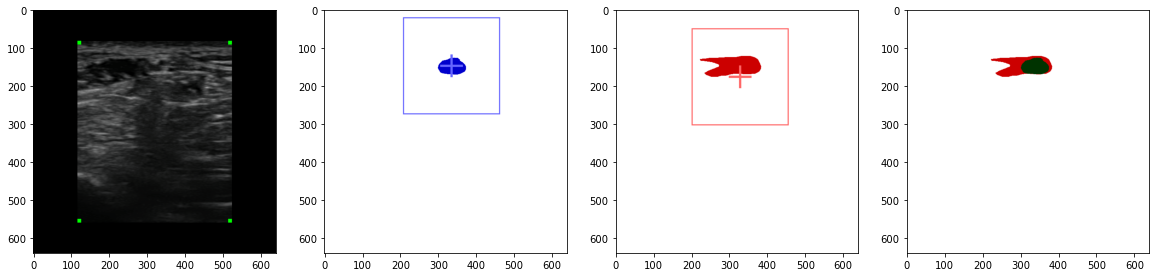

torch.Size([3, 640, 640]) torch.Size([640, 640])
[131 245] [187 321]


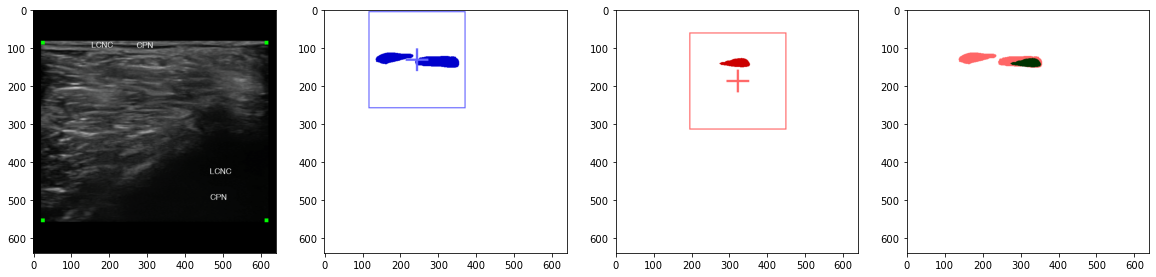

torch.Size([3, 640, 640]) torch.Size([640, 640])
[189 316] [173 328]


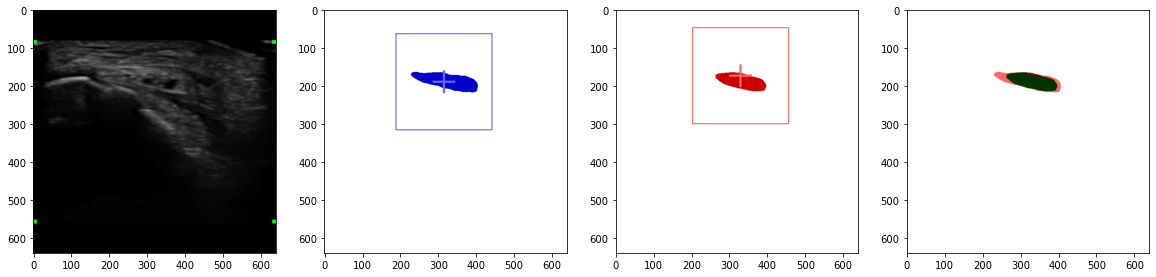

torch.Size([3, 640, 640]) torch.Size([640, 640])
[153 353] [173 328]


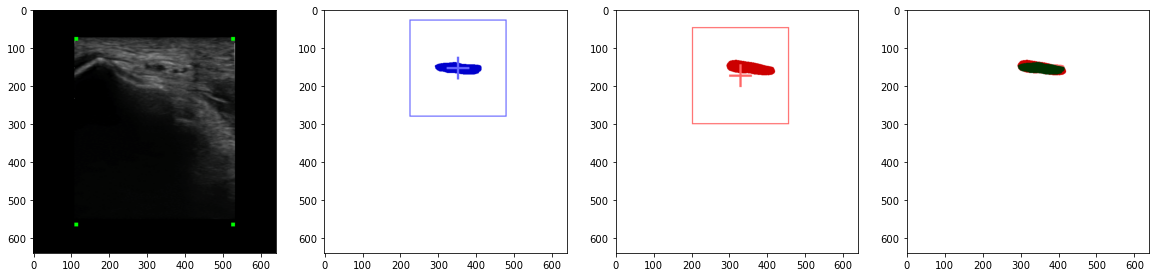

 12%|█▎        | 3/24 [00:03<00:17,  1.20it/s]

lt: [43, 201], rb: [299, 457]
anchor[0]: tensor([171, 329], device='cuda:0', dtype=torch.int32)
lt: [47, 199], rb: [303, 455]
anchor[0]: tensor([175, 327], device='cuda:0', dtype=torch.int32)
lt: [55, 194], rb: [311, 450]
anchor[0]: tensor([183, 322], device='cuda:0', dtype=torch.int32)


 21%|██        | 5/24 [00:03<00:08,  2.23it/s]

lt: [44, 201], rb: [300, 457]
anchor[0]: tensor([172, 329], device='cuda:0', dtype=torch.int32)
lt: [46, 200], rb: [302, 456]
anchor[0]: tensor([174, 328], device='cuda:0', dtype=torch.int32)
lt: [47, 200], rb: [303, 456]
anchor[0]: tensor([175, 328], device='cuda:0', dtype=torch.int32)


 38%|███▊      | 9/24 [00:03<00:03,  4.61it/s]

lt: [46, 200], rb: [302, 456]
anchor[0]: tensor([174, 328], device='cuda:0', dtype=torch.int32)
lt: [42, 201], rb: [298, 457]
anchor[0]: tensor([170, 329], device='cuda:0', dtype=torch.int32)
lt: [50, 198], rb: [306, 454]
anchor[0]: tensor([178, 326], device='cuda:0', dtype=torch.int32)


 46%|████▌     | 11/24 [00:03<00:02,  5.87it/s]

lt: [51, 196], rb: [307, 452]
anchor[0]: tensor([179, 324], device='cuda:0', dtype=torch.int32)
lt: [40, 202], rb: [296, 458]
anchor[0]: tensor([168, 330], device='cuda:0', dtype=torch.int32)
lt: [56, 196], rb: [312, 452]
anchor[0]: tensor([184, 324], device='cuda:0', dtype=torch.int32)


 62%|██████▎   | 15/24 [00:04<00:01,  8.30it/s]

lt: [49, 198], rb: [305, 454]
anchor[0]: tensor([177, 326], device='cuda:0', dtype=torch.int32)
lt: [47, 201], rb: [303, 457]
anchor[0]: tensor([175, 329], device='cuda:0', dtype=torch.int32)
lt: [49, 199], rb: [305, 455]
anchor[0]: tensor([177, 327], device='cuda:0', dtype=torch.int32)


 71%|███████   | 17/24 [00:04<00:00,  9.13it/s]

lt: [48, 199], rb: [304, 455]
anchor[0]: tensor([176, 327], device='cuda:0', dtype=torch.int32)
lt: [53, 195], rb: [309, 451]
anchor[0]: tensor([181, 323], device='cuda:0', dtype=torch.int32)
lt: [48, 198], rb: [304, 454]
anchor[0]: tensor([176, 326], device='cuda:0', dtype=torch.int32)


 88%|████████▊ | 21/24 [00:04<00:00, 10.47it/s]

lt: [47, 200], rb: [303, 456]
anchor[0]: tensor([175, 328], device='cuda:0', dtype=torch.int32)
lt: [49, 198], rb: [305, 454]
anchor[0]: tensor([177, 326], device='cuda:0', dtype=torch.int32)
lt: [48, 199], rb: [304, 455]
anchor[0]: tensor([176, 327], device='cuda:0', dtype=torch.int32)


 96%|█████████▌| 23/24 [00:04<00:00, 11.00it/s]

lt: [64, 191], rb: [320, 447]
anchor[0]: tensor([192, 319], device='cuda:0', dtype=torch.int32)
lt: [42, 201], rb: [298, 457]
anchor[0]: tensor([170, 329], device='cuda:0', dtype=torch.int32)


100%|██████████| 24/24 [00:05<00:00,  4.70it/s]

Epoch loss : 0.203138, 0.004569
Score : {'Overall Acc': 0.9955846913655599, 'Mean Acc': 0.8670688263417321, 'FreqW Acc': 0.9916197275065809, 'Mean IoU': 0.8291479979165106, 'Class IoU': {0: 0.9955460453666284, 1: 0.662749950466393}, 'Class F1': {0: 0.9977680521861607, 1: 0.7971733215574536}}


In [12]:
running_loss = [0.0, 0.0]
mse = criterion.get_criterion.__dict__['mseloss']()
dice = criterion.get_criterion.__dict__[opts.loss_type]()
metrics = utils.StreamSegMetrics(n_classes=2)
metrics.reset()

with torch.no_grad():
    for i, (ims, lbls) in tqdm(enumerate(loader), total=len(loader)):
        
        backbone.eval()
        net.eval()

        ims = ims.to(devices)
        mas = lbls[0].to(devices)
        bbox = lbls[1].to(devices)

        anchor = backbone(ims)
        mse_loss = mse(anchor, bbox)

        cims, cmas = crop(ims, mas, anchor, devices, crop_size=256)
        if i == 0:
            print('crop images, masks size: ', cims.size(), cmas.size())
        
        outputs = net(cims)
        probs = nn.Softmax(dim=1)(outputs)
        preds = recover(mas, torch.max(probs, 1)[1], anchor, devices, )

        dice_loss = dice(outputs, cmas)
        metrics.update(mas.detach().cpu().numpy(), preds.detach().cpu().numpy())

        running_loss[1] += (mse_loss.item() * ims.size(0))
        running_loss[0] += (dice_loss.item() * ims.size(0))

        #show(ims.detach().cpu(), mas.detach().cpu(), bbox.detach().cpu(), anchor.detach().cpu())
        if i == 0:
            show(ims.detach().cpu(), mas.detach().cpu(), bbox.detach().cpu(), anchor.detach().cpu(), preds.detach().cpu())
        #
        #_show(cims.detach().cpu(), cmas.detach().cpu())

        #_show(ims.detach().cpu(), result.detach().cpu())
        #print(f'{running_loss:.6f}, {mse_loss.item()}, {ims.size(0)}')
    #print(f'running loss : {running_loss:.6f} / {len(loader)}')
    epoch_loss = [running_loss[0] / len(loader.dataset), running_loss[1] / len(loader.dataset)]

print(f"Epoch loss : {epoch_loss[0]:.6f}, {epoch_loss[1]:.6f}")
print(f"Score : {metrics.get_results()}")